In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import requests
import dateutil.parser as dp
import time
from scipy import stats

# FTX Betas Finder

This notebook lets you find betas between various spot markets on FTX. 

### Settings

```CANDLE_RESOLUTION``` can be 15, 60, 300, 900, 3600, 14400, 86400, or any multiple up to 30*86400. The API has a hard limit of up to 1500 candles per query, but we try to gently bypass this.

```start_time``` or ```end_time``` can either be seconds since the unix epoch (e.g. ```1601856000```), or a string formatted in ISO8601 with UTC (e.g. ```'2021-12-31'```, ```'2021-10-06T22:54:00Z'```). 

In [1]:
# Every single spot w/ 24hr vol > $5m ['BTC','ETH','FTT','SOL','DOGE','BNB','FTM','USDT','LTC','SHIB','XRP','LINK','SRM','AXS','YFI','RAY','SUSHI','MATIC',
#                                     'BCH','DYDX','ATLAS','OMG','POLIS','STEP','UNI','TRX','AGLD', 'HT', 'RUNE', 'AAVE', 'WBTC','STORJ','AVAX']
syms = ['BTC','ETH','FTT','SOL','BNB', 'LTC','XRP','LINK','SRM','YFI','SUSHI','BCH','UNI','TRX', 'RUNE']
against = 'USD' # or BTC
start_time = '2021-04-03'
end_time = '2021-10-03'
candle_resolution = 14400

DROPPED_COLUMNS = ['time', 'open', 'high', 'low', 'close', 'volume', 'logReturn']

### Functions

In [3]:
def get_market_data_for_sym(sym, against, start_time, end_time):
    df = pd.DataFrame() #initialise the df in case we need to divide our requests up
    parsed_start = parse_timestamp(start_time)
    parsed_end = parse_timestamp(end_time)
    total_wanted_candles = (parsed_end - parsed_start)/candle_resolution
    if total_wanted_candles <= 1500:
        df = get_data_from_api(sym, against, parsed_start, parsed_end)
    else: #divide our requests up to make a big boy df
        current_start = parsed_start
        wanted_candles = 1500
        while parsed_end > current_start:
            time.sleep(0.5) # Make sure we don't get rate limited
            current_end = current_start + wanted_candles * candle_resolution
            df = df.append(get_data_from_api(sym, against, current_start, current_end))
            current_start = current_end
            total_wanted_candles -= wanted_candles
            wanted_candles = (total_wanted_candles - 1500 if False else total_wanted_candles)
        df = df.drop_duplicates()
    df = add_log_return_with_zero_mean(df)
    df = df.drop(DROPPED_COLUMNS, axis=1)
    df.columns = ['{}{}'.format(c, '' if c == 'startTime' else sym) for c in df.columns]
    return df

def get_data_from_api(sym, against, start_time, end_time):
    url = f"https://ftx.com/api/markets/{sym}/{against}/candles?resolution={candle_resolution}&start_time={start_time}&end_time={end_time}"
    r = requests.get(url).json()['result'] # convert to json and get the result
    df = pd.DataFrame(r)
    return df

def add_log_return_with_zero_mean(df):
    df['logReturn'] = np.log((df['close']/df['open']))
    meanLogReturn = df['logReturn'].mean()
    df['zeroMeanLogReturn'] = df['logReturn'] - meanLogReturn
    return df

def parse_timestamp(timestamp):
    if type(timestamp) is int:
        return timestamp
    parsed_ts = dp.parse(timestamp)
    timestamp_in_seconds = parsed_ts.timestamp()
    return int(timestamp_in_seconds)

def generate_dataframe_with_symbols():
    return_df = pd.DataFrame(columns=['startTime'])
    for sym in syms:
        df = get_market_data_for_sym(sym,against,start_time,end_time)
        return_df = pd.merge(return_df,df,how='outer')
    return_df = return_df.rename(columns=lambda x: x.replace('zeroMeanLogReturn','')) #This needs to be done to make the heatmap readable
    return return_df

def find_counts_where_not_mode(df):
    described_df = df.describe()
    count_series = described_df.iloc[0]
    count_mode = stats.mode(count_series)[0][0]
    return count_series.where(count_series != count_mode).dropna().index

def get_betas(df):
    betas = df.corr()
    stds = df.describe().iloc[2]
    for column in betas.columns:
        for index in betas[column].index:
            betas.at[index, column] = betas.at[index, column] * stds[index] / stds[column]
    return betas



### Generate Table

In [4]:
df = generate_dataframe_with_symbols()
print("These columns deviate from the mode. This could be due to an error or due to them not having been released before the start_date. " + str(find_counts_where_not_mode(df)))
# df = df.dropna() # sometimes the last row of a df could have some missing values for some syms but not others - unclear what causes this. Run this to drop them.
df.head()

These columns deviate from the mode. This could be due to an error or due to them not having been released before the start_date. Index([], dtype='object')


,startTime,BTC,ETH,FTT,SOL,BNB,LTC,XRP,LINK,SRM,YFI,SUSHI,BCH,UNI,TRX,RUNE
0,2021-04-03T00:00:00+00:00,0.004641,-0.019771,-0.004695,0.061041,0.000490,-0.002588,0.024667,-0.017299,-0.052443,-0.026993,-0.008479,0.005113,0.029297,-0.033241,-0.015851
1,2021-04-03T04:00:00+00:00,0.001338,0.008425,0.014134,0.002786,0.011066,0.022114,0.010648,0.026839,0.013959,-0.000071,-0.000270,0.008575,0.029188,0.014770,0.024482
2,2021-04-03T08:00:00+00:00,-0.000384,-0.007549,-0.002301,0.058260,0.010135,-0.011523,-0.012622,-0.022176,0.077821,0.002800,-0.017770,-0.014576,-0.027600,0.118746,0.020544
3,2021-04-03T12:00:00+00:00,-0.007010,-0.012898,-0.017968,-0.069763,-0.022875,-0.028608,-0.009320,-0.031787,-0.044895,-0.024346,-0.057242,-0.029326,-0.014042,0.046604,0.051470
4,2021-04-03T16:00:00+00:00,-0.003626,0.011960,-0.005612,0.051843,-0.006865,-0.005776,-0.021654,-0.004374,0.040496,-0.000344,0.023357,-0.013394,-0.000840,-0.007603,0.008664


<AxesSubplot:>

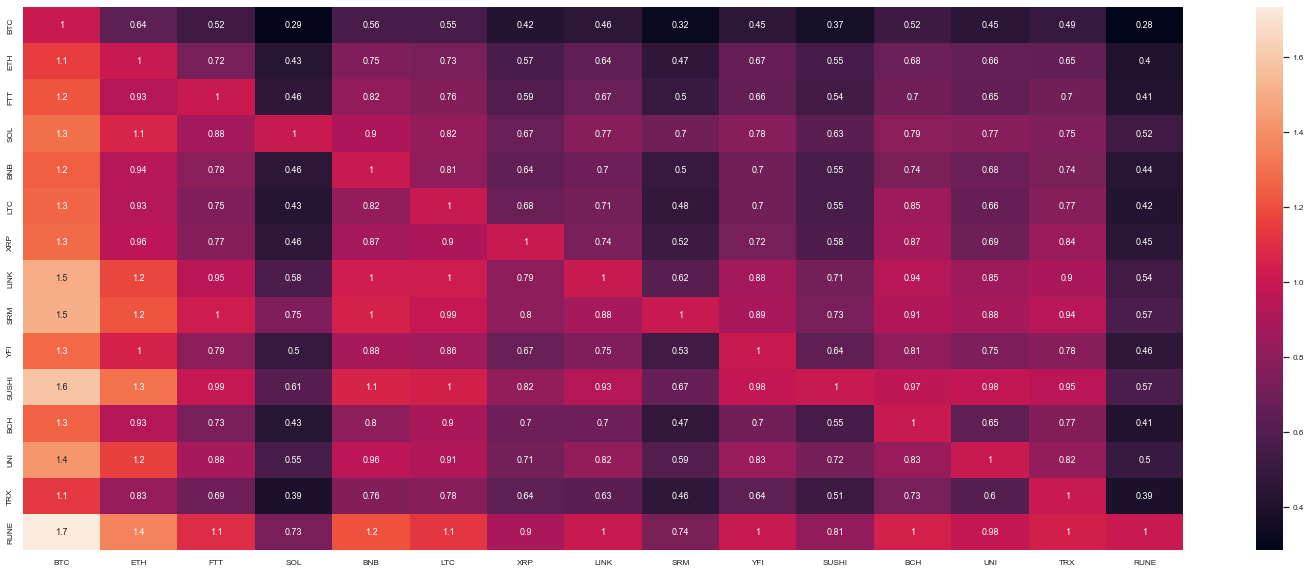

In [5]:
betas = get_betas(df)
plt.figure(figsize=(26, 10))
sns.set(font_scale=0.75)
sns.heatmap(data=betas, annot=True)